In [ ]:
pip install ta;pip install pycoingecko

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=22c6426d3618fc21e9d9eb426d93b4854cdd7fb509c4d6fe795299ff97738b85
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
import time
import math

# Create an instance of the CoinGeckoAPI class and assigns it to the variable cg
cg = CoinGeckoAPI() # connect

# Check API connectivity using ping method
coin_list = ['bitcoin','ethereum']
# Function to fetch hourly data for the last 30 days
def fetch_hourly_data(coin_id, vs_currency='usd'):
    end_time = int(time.time())  # Current timestamp
    start_time = end_time - (30 * 24 * 60 * 60)  # Timestamp for 30 days ago

    # Fetch market chart data
    data = cg.get_coin_market_chart_range_by_id(
        id=coin_id,
        vs_currency=vs_currency,
        from_timestamp=start_time,
        to_timestamp=end_time
    )

    # Convert the hourly prices to a DataFrame
    prices = data['prices']  # Each entry is [timestamp, price]
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert to datetime
    return df

# Store DataFrames in a list
dataframes = [fetch_hourly_data(coin) for coin in coin_list]

# Example: Access Bitcoin's data
bitcoin_data = dataframes[0]
ethereum_data = dataframes[1]

# Print the first few rows of Bitcoin's data
print(bitcoin_data.head())

                timestamp         price
0 2025-01-01 10:01:24.792  93256.069306
1 2025-01-01 11:08:02.261  93051.983232
2 2025-01-01 12:01:10.869  93297.607578
3 2025-01-01 13:02:53.459  93547.861335
4 2025-01-01 14:07:57.569  94216.980764


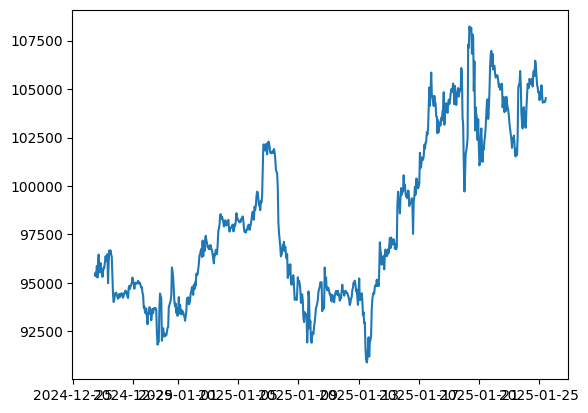

In [ ]:
bitcoin_data.index = bitcoin_data['timestamp']
# ethereum_data.index = ethereum_data['timestamp']
plt.plot(bitcoin_data['price'])

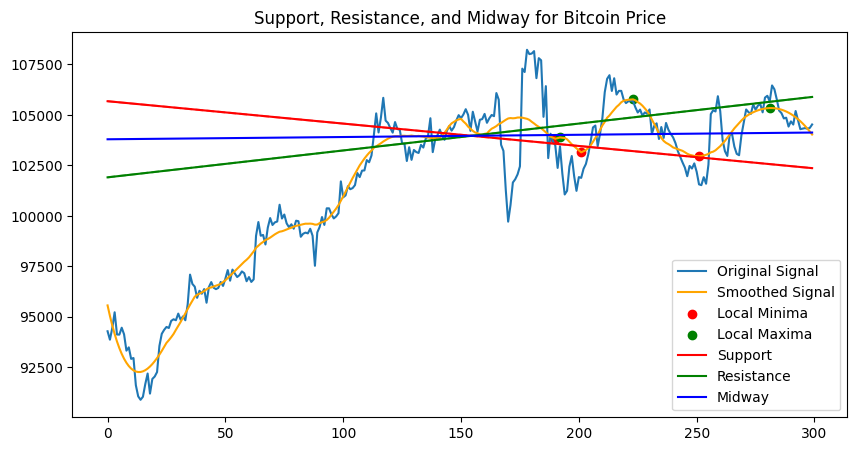

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

# Example utility function for finding local minima and maxima
def local_min_max(signal):
    local_min = []
    local_max = []
    for i in range(1, len(signal) - 1):
        if signal[i] < signal[i - 1] and signal[i] < signal[i + 1]:
            local_min.append((i, signal[i]))
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1]:
            local_max.append((i, signal[i]))
    return local_min, local_max

# Regression coefficients for a given set of points
def regression_ceof(points):
    x = np.array([p[0] for p in points]).reshape(-1, 1)
    y = np.array([p[1] for p in points])
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    return slope, intercept

# Compute support, resistance, and midway for bitcoin_data['price']
support = {}
resistance = {}
midway = {}

plt.figure(figsize=(10, 5))
bitcoin_data['price'] = bitcoin_data['price'].astype(float)  # Ensure numeric

# Smoothing the signal
signal = bitcoin_data['price'].values[-300:]
signal_index = np.arange(signal.shape[0])
smoothed_signal = savgol_filter(signal, 51, 3)  # Window size = 51, polynomial order = 3

# Identify local minima and maxima
local_min, local_max = local_min_max(smoothed_signal)
local_min = local_min[-3:]  # Take the last 3 minima
local_max = local_max[-3:]  # Take the last 3 maxima

# Plot the signal
plt.plot(signal, label='Original Signal')
plt.plot(smoothed_signal, label='Smoothed Signal', color='orange')

# Scatter local minima and maxima
for pt in local_min:
    plt.scatter(pt[0], pt[1], color='red', label='Local Minima' if pt == local_min[0] else None)
for pt in local_max:
    plt.scatter(pt[0], pt[1], color='green', label='Local Maxima' if pt == local_max[0] else None)

# Calculate support and resistance
local_min_slope, local_min_int = regression_ceof(local_min)
local_max_slope, local_max_int = regression_ceof(local_max)

support_line = (local_min_slope * signal_index) + local_min_int
resistance_line = (local_max_slope * signal_index) + local_max_int
support_error = support_line - 1
resistance_error = resistance_line + 1
midway_line = (support_line + resistance_line) / 2

# Plot support, resistance, and midway lines
plt.plot(support_line, label='Support', color='red')
plt.plot(support_error, linestyle='dashed', color='red', alpha=0.5)
plt.plot(resistance_line, label='Resistance', color='green')
plt.plot(resistance_error, linestyle='dashed', color='green', alpha=0.5)
plt.plot(midway_line, label='Midway', color='blue')

# Add title and legend
plt.title("Support, Resistance, and Midway for Bitcoin Price")
plt.legend()
plt.show()

<ipython-input-10-260201d041c6>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bitcoin_data['rolling_std_10'] = bitcoin_data['price'].rolling(window=10).std().fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 446ms/step - loss: 0.1181 - val_loss: 0.0140
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - loss: 0.0012 - val_loss: 9.4880e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - loss: 0.0012 - val_loss: 0.0017
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


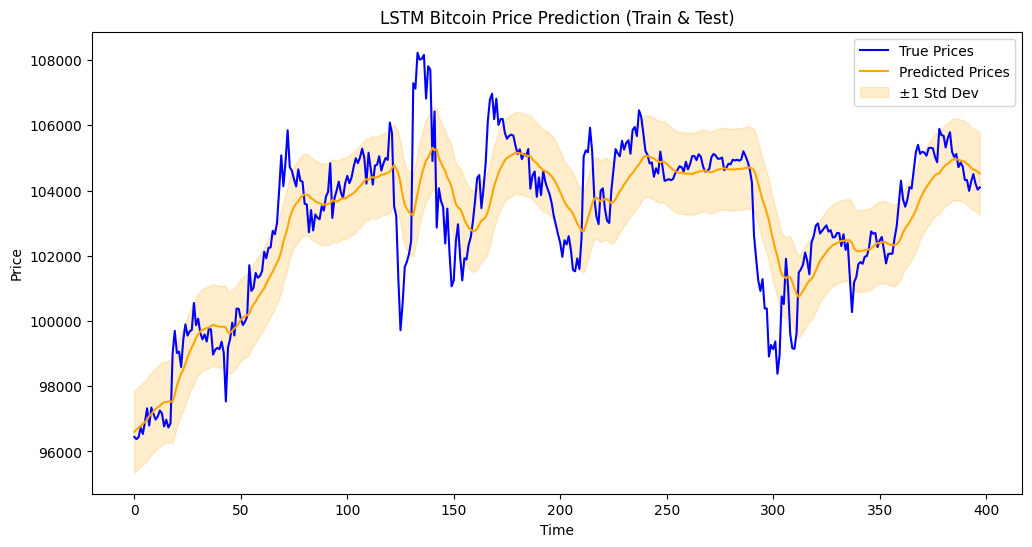

In [ ]:
import pandas as pd
import numpy as np
from pycoingecko import CoinGeckoAPI
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import EarlyStopping

# Initialize API
cg = CoinGeckoAPI()

# Fetch Bitcoin data
def fetch_data(coin_id, days):
    if days > 90:
        days = 90  # API limit
    data = cg.get_coin_market_chart_by_id(
        id=coin_id, vs_currency="usd", days=days
    )
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df.set_index('timestamp')

bitcoin_data = fetch_data("bitcoin", 90)

# Feature engineering
bitcoin_data['price_pct_change'] = bitcoin_data['price'].pct_change().fillna(0)
bitcoin_data['price_diff'] = bitcoin_data['price'].diff().fillna(0)
bitcoin_data['rolling_std_10'] = bitcoin_data['price'].rolling(window=10).std().fillna(method='bfill')

# Selecting features
features = ['price', 'price_pct_change', 'price_diff', 'rolling_std_10']
bitcoin_data = bitcoin_data[features].dropna()

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(bitcoin_data)

# Create sequences
def create_dataset(data, look_back=7*24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 7 * 24  # 7 days
X, y = create_dataset(scaled_data, look_back)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model = build_lstm_model((look_back, X.shape[2]))
history = model.fit(X_train, y_train, epochs=50, batch_size=48, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Predictions on test data
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(np.c_[y_pred, np.zeros((len(y_pred), X.shape[2]-1))])[:, 0]
y_test_inverse = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), X.shape[2]-1))])[:, 0]

# Compute error bounds
error_std = np.std(y_test_inverse - y_pred_inverse)
y_pred_upper, y_pred_lower = y_pred_inverse + error_std, y_pred_inverse - error_std

# Plot 1: Train & Test vs Predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_inverse)), y_test_inverse, label="True Prices", color='blue')
plt.plot(range(len(y_pred_inverse)), y_pred_inverse, label="Predicted Prices", color='orange')
plt.fill_between(range(len(y_pred_inverse)), y_pred_lower, y_pred_upper, color='orange', alpha=0.2, label="±1 Std Dev")
plt.title("LSTM Bitcoin Price Prediction (Train & Test)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - loss: 0.1104
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 366ms/step - loss: 0.0031
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - loss: 0.0016
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - loss: 0.0015
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0015


<ipython-input-11-5c8f8eeabc45>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=bitcoin_data.index[-1] + pd.Timedelta(hours=1), periods=to_predict, freq='H')


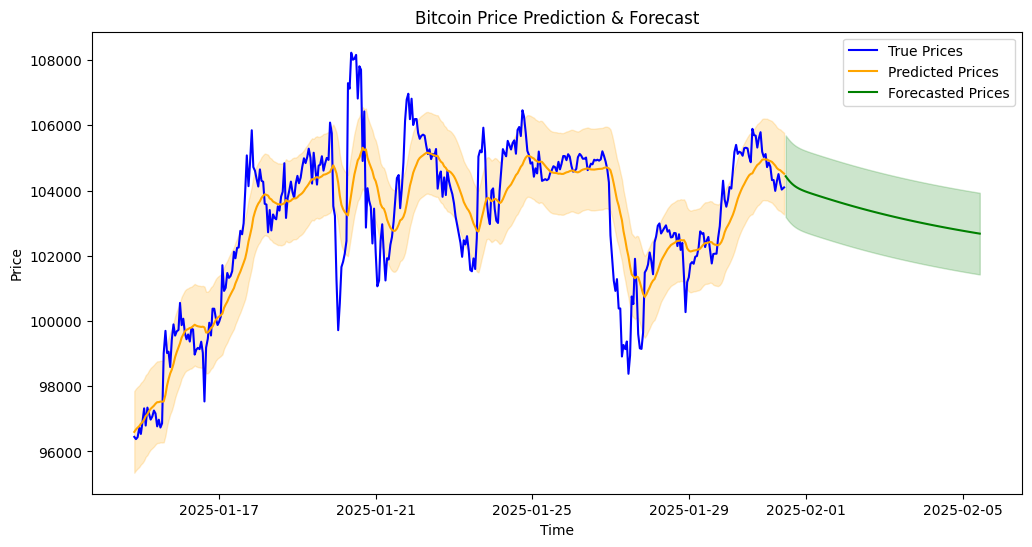

In [ ]:

# Retrain on full dataset for forecasting
model = build_lstm_model((look_back, X.shape[2]))
model.fit(X, y, epochs=5, batch_size=48, verbose=1, callbacks=[early_stopping])

# Forecasting next 5 days
to_predict = 24 * 5
x_input = X_test[-1].reshape(1, look_back, X.shape[2])
forecast = []

for _ in range(to_predict):
    yhat = model.predict(x_input, verbose=0)
    forecast.append(yhat[0, 0])
    next_input = np.append(x_input[:, 1:, :], [[[yhat[0, 0]] + list(x_input[0, -1, 1:])]], axis=1)
    x_input = next_input

# Inverse transform forecast
forecast_array = np.array(forecast).reshape(-1, 1)
forecast_inverse = scaler.inverse_transform(np.c_[forecast_array, np.zeros((len(forecast_array), X.shape[2] - 1))])[:, 0]

# Forecast index
forecast_index = pd.date_range(start=bitcoin_data.index[-1] + pd.Timedelta(hours=1), periods=to_predict, freq='H')

# Plot 2: Train + Test + Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data.index[-len(y_test_inverse):], y_test_inverse, label="True Prices", color='blue')
plt.plot(bitcoin_data.index[-len(y_pred_inverse):], y_pred_inverse, label="Predicted Prices", color='orange')
plt.fill_between(bitcoin_data.index[-len(y_pred_inverse):], y_pred_lower, y_pred_upper, color='orange', alpha=0.2)
plt.plot(forecast_index, forecast_inverse, label="Forecasted Prices", color='green')
plt.fill_between(forecast_index, forecast_inverse + error_std, forecast_inverse - error_std, color='green', alpha=0.2)
plt.title("Bitcoin Price Prediction & Forecast")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
bitcoin_data.corr()

,price,volume,price_pct_change,price_diff,rolling_std_10
price,1.000000,0.199382,0.010869,0.014796,0.176837
volume,0.199382,1.000000,0.007974,0.004442,0.478451
price_pct_change,0.010869,0.007974,1.000000,0.994775,0.011114
price_diff,0.014796,0.004442,0.994775,1.000000,0.007542
rolling_std_10,0.176837,0.478451,0.011114,0.007542,1.000000


In [ ]:
forecast_df

,Forecasted Price
2025-01-26 12:08:05.625228,104298.537465
2025-01-26 13:08:05.625228,104212.741555
2025-01-26 14:08:05.625228,104105.707202
2025-01-26 15:08:05.625228,103988.316491
2025-01-26 16:08:05.625228,103867.934485
...,...
2025-01-31 07:08:05.625228,98680.944970
2025-01-31 08:08:05.625228,98653.383186
2025-01-31 09:08:05.625228,98626.006381
2025-01-31 10:08:05.625228,98598.831591
